In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# Funções

In [3]:
def FetchInput(option, instance, data, distance_option):
    if option == 1:
        with open ('.\\1\\body_gyro_x_test.txt', 'r') as f:
            x_coords = f.readlines()

        with open ('.\\1\\body_gyro_y_test.txt', 'r') as f:
            y_coords = f.readlines()

        x = []
        counter = 0
        for line in x_coords:
            line = line.split(' ')
            for i in range(len(line)):
                if line[i] != '':
                    counter += 1
                    # print(line[i])
                    x.append(float(line[i]))
                if counter == 1000:
                    break

        y = []
        counter = 0
        for line in y_coords:
            line = line.split(' ')
            for i in range(len(line)):
                if line[i] != '':
                    counter += 1
                    y.append(float(line[i]))
                if counter == 1000:
                    break
                
        labels = []
    else:
        df = pd.read_csv(f'sinteticos/data_{instance}.csv')
        # print(df.head())
        for column in df.columns[:2]:
            if column != 'label':
                df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            # else:
        # print(df['label'].unique()) 

        x = []
        y = []
        labels = []
        for curr_x, curr_y, label in df[['x', 'y', 'label']].values:
            x.append(curr_x)
            y.append(curr_y)
            labels.append(label)

    # for i in range(len(x)):
    #     plt.scatter(x[i], y[i], color='black')
    # Numpy on top    
    points = np.vstack((x, y)).T
    distances = np.linalg.norm(points[:, np.newaxis, :] - points[np.newaxis, :, :], ord=distance_option, axis=-1)
    
    return points.tolist(), distances.tolist(), labels


In [34]:
def KmeansRefined(points, distances, difference, k):
    rmax = max([max(i) for i in distances])
    #print('rmax:', rmax)
    original_rmax = rmax
    rmin = 0
    curr_r = 0
    centers = []
    while True:
        curr_r = (rmin + rmax) / 2
        centers = []

        copy_points = [i for i in range(len(points))]
        while copy_points != []:
            i = random.choice(copy_points)
            centers.append(points[i])
            copy_points.remove(i)
            aux = [i for i in copy_points]
            for j in aux:
                distance = distances[i][j]
                if distance <= 2 * curr_r:
                    copy_points.remove(j)

        if (rmax - rmin)/original_rmax < difference and len(centers) <= k:
            break

        if len(centers) > k:
            rmin = (rmin + rmax) / 2

        else:
            rmax = (rmin + rmax) / 2
        

    return centers, (rmax + rmin) / 2

# Dados sintéticos 1

Maior raio: 0.17153926732093294
Tempo de execução: 0.66s


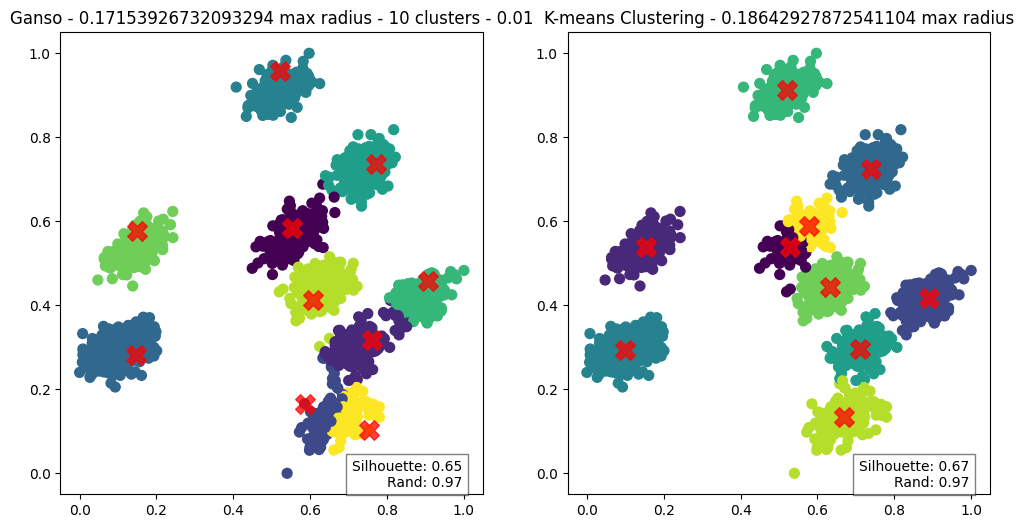

Maior raio: 0.15871236709060152
Tempo de execução: 0.56s


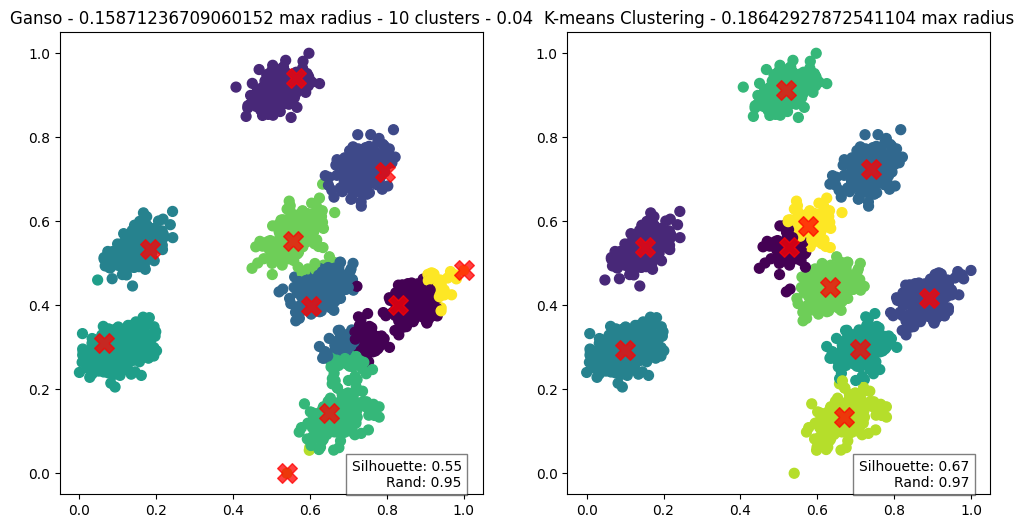

Maior raio: 0.17876310666576942
Tempo de execução: 0.61s


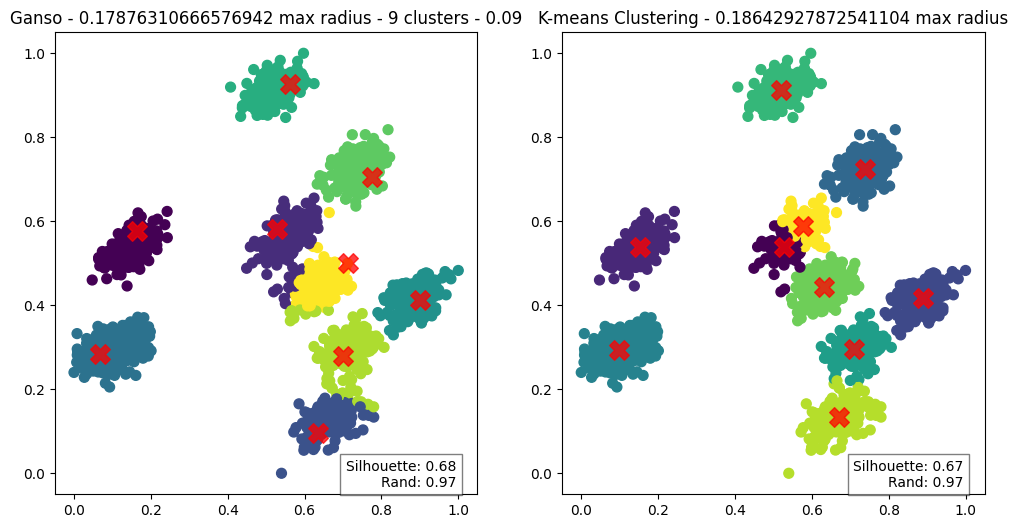

Maior raio: 0.19286257885994074
Tempo de execução: 0.59s


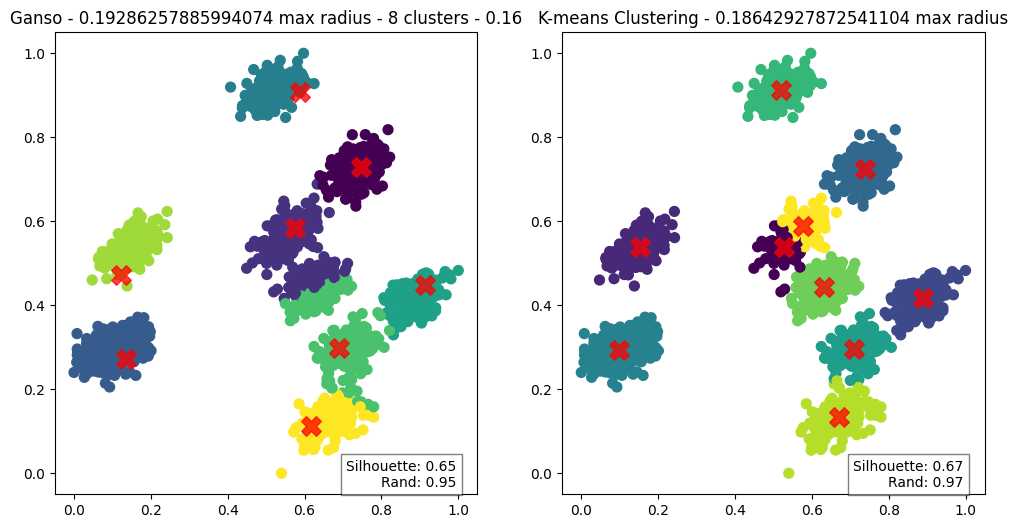

Maior raio: 0.18119939467429005
Tempo de execução: 0.50s


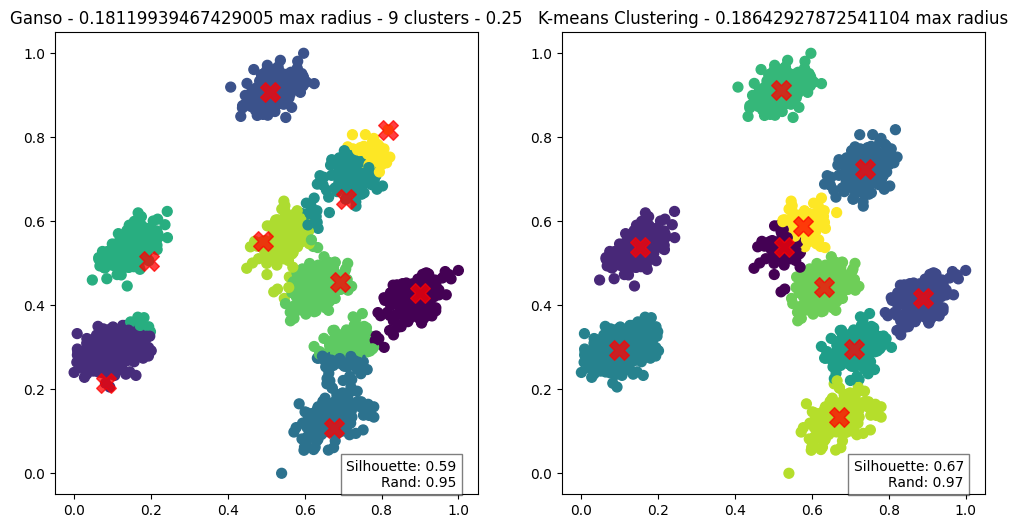

In [44]:
refinamento = [0.01, 0.04, 0.09, 0.16, 0.25]
#refinamento = [0.04]
for r in refinamento:
    inicio = time.time()
    points, distances, input_labels = FetchInput(2, 10, 1, 2)
    #print(r)
        
    # Configurar o tamanho da figura
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Parte 1: Algoritmo refinamento_k_means

    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])

    fim = time.time()
    centers, max_r = KmeansRefined(points, distances, r, k)
    #print('tepo de execução:', fim - inicio)
    # df = pd.DataFrame(columns=['x', 'y', 'label'])

    labels = []
    d = []
    for point in points:
        current_distance = 0
        nearest_center = 0
        for center in centers:
            if point == center:
                current_distance = 0
                nearest_center = center
                break
            distance = ((point[0] - center[0])**2 + (point[1] - center[1])**2)**0.5
            if distance < current_distance or (current_distance == 0):
                current_distance = distance
                nearest_center = center
        d.append(current_distance) 
            
        labels.append(centers.index(nearest_center))
    max_r = max(d)
    print('Maior raio:',max_r)
    ss = silhouette_score(np.array(points), labels)
    rs = rand_score(input_labels, labels)

    # Plotar o resultado do greedy_k_means
    ax[0].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
    ax[0].set_title(f'Ganso - {max_r} max radius - {len(centers)} clusters - {r}')
    ax[1].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax[0].transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.5))


    # Parte 2: K-means do sklearn
    X, y = np.array(points), input_labels
    kmeans = KMeans(n_clusters=len([x for i, x in enumerate(y) if x not in y[:i]]), random_state=42)
    labels = kmeans.fit_predict(X)
    distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
    max_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X)])

    # Imprimir métricas
    sil_score = silhouette_score(np.array(points), labels)
    rand_score_value = rand_score(y, labels)

    # Plotar o resultado do K-means
    # ax[1].scatter(X.values[:, 0], X.values[:, 1], c=y, s=50, cmap='viridis')
    ax[1].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax[1].transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.5))
    # Configurar título e rótulos
    ax[1].set_title(f'K-means Clustering - {max_r_sklearn} max radius')
    print(f'Tempo de execução: {time.time() - inicio:.2f}s')

    # Exibir os gráficos
    plt.show()

In [40]:
type = 2 
data = 1
metrics = []
csv_files = [f'data_{i}.csv' for i in range(10)]
refinamento = 0.04
for i,csv in enumerate(tqdm(csv_files)):

    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    points, distances, input_labels = FetchInput(2, i+1, data, type)
    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])
    for j in range(30):
        start = time.time()
        centers, max_r = KmeansRefined(points, distances, refinamento, k)
        end = time.time()
        #print('Tempo de execução:', end - start)
        labels = []
        r_v = []
        max_distance = 0

        for point in points:
            current_distance = 0
            nearest_center = 0
            for center in centers:
                if point == center:
                    current_distance = 0
                    nearest_center = center
                    break
                point1 = np.array([point[0], point[1]])
                center1 = np.array([center[0], center[1]])
                distance = np.linalg.norm(point1 - center1,type)
                if distance < current_distance or (current_distance == 0):
                    current_distance = distance
                    nearest_center = center
            r_v.append(current_distance) 

            labels.append(centers.index(nearest_center))
        
        radius.append(max(r_v))
        times.append(end - start)
        sillhouette_s.append(silhouette_score(np.array(points), labels))
        rand_s.append(rand_score(input_labels, labels))
    print('Instância:', i, ' Finalizada')
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

 10%|█         | 1/10 [00:09<01:29,  9.98s/it]

Instância: 0  Finalizada


 20%|██        | 2/10 [00:15<00:59,  7.50s/it]

Instância: 1  Finalizada


 30%|███       | 3/10 [00:22<00:49,  7.07s/it]

Instância: 2  Finalizada


 40%|████      | 4/10 [00:28<00:39,  6.62s/it]

Instância: 3  Finalizada


 50%|█████     | 5/10 [00:33<00:30,  6.08s/it]

Instância: 4  Finalizada


 60%|██████    | 6/10 [00:46<00:33,  8.39s/it]

Instância: 5  Finalizada


 70%|███████   | 7/10 [00:53<00:24,  8.11s/it]

Instância: 6  Finalizada


 80%|████████  | 8/10 [01:07<00:19,  9.84s/it]

Instância: 7  Finalizada


 90%|█████████ | 9/10 [01:21<00:11, 11.16s/it]

Instância: 8  Finalizada


100%|██████████| 10/10 [01:28<00:00,  8.89s/it]

Instância: 9  Finalizada


In [41]:
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.146177,0.009123,0.119174,0.593508,0.032242,0.967594,0.007014
1,0.185106,0.013336,0.086622,0.490081,0.046713,0.923136,0.013920
2,0.157595,0.006311,0.091889,0.549970,0.042924,0.942730,0.007138
3,0.187752,0.012929,0.091299,0.734076,0.012602,0.992734,0.007749
4,0.159556,0.009520,0.086232,0.709171,0.047750,0.960188,0.006543
5,0.140493,0.005001,0.149828,0.452204,0.028508,0.938275,0.008130
6,0.169919,0.013159,0.130029,0.537569,0.052003,0.956405,0.011310
7,0.126322,0.013070,0.169023,0.450559,0.050558,0.939385,0.008790
8,0.157748,0.018601,0.168871,0.563112,0.059384,0.958206,0.010362
9,0.169162,0.012319,0.109643,0.614469,0.047269,0.957713,0.012081


In [43]:
pd.read_csv('/home/bdlemos/Faculdade/Semestre_5/ALG2/sinteticos/sklearn_metrics_2.csv')

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.132084,0.000000e+00,0.049112,0.641315,3.330669e-16,0.989548,2.220446e-16
1,0.168114,4.299875e-17,0.077137,0.507378,1.110223e-16,0.969387,2.220446e-16
2,0.147805,2.775558e-17,0.058811,0.545232,1.110223e-16,0.982632,0.000000e+00
3,0.153844,5.551115e-17,0.065680,0.745933,0.000000e+00,0.999262,2.220446e-16
4,0.136488,5.551115e-17,0.070165,0.644060,1.110223e-16,0.966886,2.220446e-16
5,0.127504,2.775558e-17,0.025355,0.512045,0.000000e+00,0.963944,1.110223e-16
6,0.124548,2.775558e-17,0.061553,0.580904,1.110223e-16,0.988027,2.220446e-16
7,0.134056,0.000000e+00,0.029068,0.505451,1.110223e-16,0.957697,2.220446e-16
8,0.123871,4.163336e-17,0.026064,0.560862,2.220446e-16,0.978110,2.220446e-16
9,0.186429,2.775558e-17,0.060210,0.668528,0.000000e+00,0.974079,3.330669e-16


In [ ]:
#df_greedy.to_csv(f'sinteticos/{data}/greedy_kmeans_004_{type}.csv', index=False)

Text(0.5, 1.0, 'Densidade do raio médio - algoritmo de refinamento de raios')

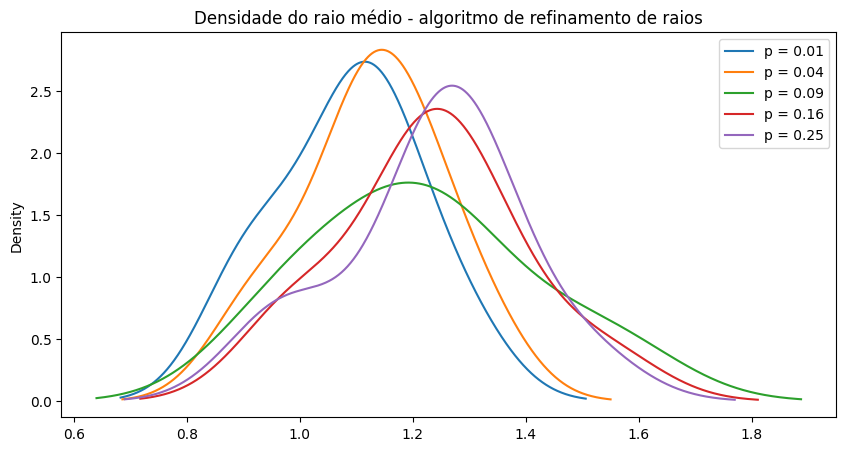

In [64]:
df_sklearn = pd.read_csv(f'sinteticos/sklearn_metrics_{type}.csv')
df_greedy1 = pd.read_csv(f'ganso-sinteticos1-euclidiano/greedy_kmeans_001_{type}.csv')
df_greedy2 = pd.read_csv(f'ganso-sinteticos1-euclidiano/greedy_kmeans_004_{type}.csv')
df_greedy3 = pd.read_csv(f'ganso-sinteticos1-euclidiano/greedy_kmeans_009_{type}.csv')
df_greedy4 = pd.read_csv(f'ganso-sinteticos1-euclidiano/greedy_kmeans_016_{type}.csv')
df_greedy5 = pd.read_csv(f'ganso-sinteticos1-euclidiano/greedy_kmeans_025_{type}.csv')
df_test = pd.read_csv('sinteticos/greedy_metrics_2.csv')
df_media1 = df_greedy1 / df_sklearn
df_media2 = df_greedy2 / df_sklearn
df_media3 = df_greedy3 / df_sklearn
df_media4 = df_greedy4 / df_sklearn
df_media5 = df_greedy5 / df_sklearn
ax1 = df_media1[['mean_radius']].plot(kind='density', figsize=(10, 5), legend='001')
ax2 = df_media2[['mean_radius']].plot(kind='density', ax=ax1, legend='004')
ax3 = df_media3[['mean_radius']].plot(kind='density', ax=ax1, legend='009')
ax4 = df_media4[['mean_radius']].plot(kind='density', ax=ax1, legend='016')
ax5 = df_media5[['mean_radius']].plot(kind='density', ax=ax1, legend='025')
plt.legend(['p = 0.01', 'p = 0.04', 'p = 0.09', 'p = 0.16', 'p = 0.25'])
plt.title('Densidade do raio médio - algoritmo de refinamento de raios')

In [72]:
from scipy import stats
baseline = df_sklearn['mean_rand_s'].values
dfs = [df_greedy1,df_greedy2, df_greedy3, df_greedy4, df_greedy5, df_test]
for i,df in enumerate(dfs):
    t = stats.ttest_ind(baseline, df['mean_rand_s'].values)
    print(i, t)

0 TtestResult(statistic=2.9705572419143773, pvalue=0.008193074379412382, df=18.0)
1 TtestResult(statistic=3.25705905196035, pvalue=0.0043768026816495675, df=18.0)
2 TtestResult(statistic=3.8697446989155346, pvalue=0.0011226122781542863, df=18.0)
3 TtestResult(statistic=4.199367872757659, pvalue=0.0005389749760067363, df=18.0)
4 TtestResult(statistic=4.024098906189905, pvalue=0.0007959457863526026, df=18.0)
5 TtestResult(statistic=4.4849006458503045, pvalue=0.0002863817065215899, df=18.0)


# Dados reais 

In [3]:
def FetchRealInput(df):
    for column in df.columns[:2]:
        if column != 'label':
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    # print(df.shape)
    # print(len(df))
    labels = []
    for label in df[['label']].values:
        labels.append(label[0])
    points = np.vstack(df.loc[:, df.columns != 'label'].values)
    # print(set(labels))
    distances = np.linalg.norm(points[:, np.newaxis, :] - points[np.newaxis, :, :], ord=2, axis=-1)
    # print(distances.shape)
    return points.tolist(), distances.tolist(), labels

## 2 - Drybeans

In [4]:
df_drybeans = pd.read_excel('reais/2/Dry_Bean_Dataset.xlsx')

In [5]:
all_classes = df_drybeans['Class'].unique()
dic = {all_classes[i]: i for i in range(len(all_classes))}

df_drybeans['Class'] = df_drybeans['Class'].map(dic)
# df_drybeans.rename(columns={'Class': 'label'}, inplace=True)
df_drybeans = df_drybeans[['Area', 'Perimeter', 'Class']]
df_drybeans.rename(columns={'Area': 'x', 'Perimeter': 'y', 'Class': 'label'}, inplace=True)

In [8]:
points, distances, input_labels = FetchRealInput(df_drybeans)

(13611, 3)
{0, 1, 2, 3, 4, 5, 6}
(13611, 13611)


Algoritmo refinamento_k_means - refinamento = 0.01
Maior raio ganso: 0.18460143103255275
Silhouette ganso: 0.5849806903293633
Rand ganso: 0.6411158023578521
Maior raio sklearn: 0.32772376387212354
Silhouette sklearn: 0.5020485704318919
Rand sklearn: 0.8088363611767312
Tempo de execução: 43.90s
Algoritmo refinamento_k_means - refinamento = 0.04
Maior raio ganso: 0.14598057373223178
Silhouette ganso: 0.5510391698798082
Rand ganso: 0.6696552163070335
Maior raio sklearn: 0.32772376387212354
Silhouette sklearn: 0.5020485704318919
Rand sklearn: 0.8088363611767312
Tempo de execução: 42.19s
Algoritmo refinamento_k_means - refinamento = 0.09
Maior raio ganso: 0.17964735597342302
Silhouette ganso: 0.468559262231392
Rand ganso: 0.747049839912622
Maior raio sklearn: 0.32772376387212354
Silhouette sklearn: 0.5020485704318919
Rand sklearn: 0.8088363611767312
Tempo de execução: 40.15s
Algoritmo refinamento_k_means - refinamento = 0.16
Maior raio ganso: 0.16888073221108452
Silhouette ganso: 0.52110666

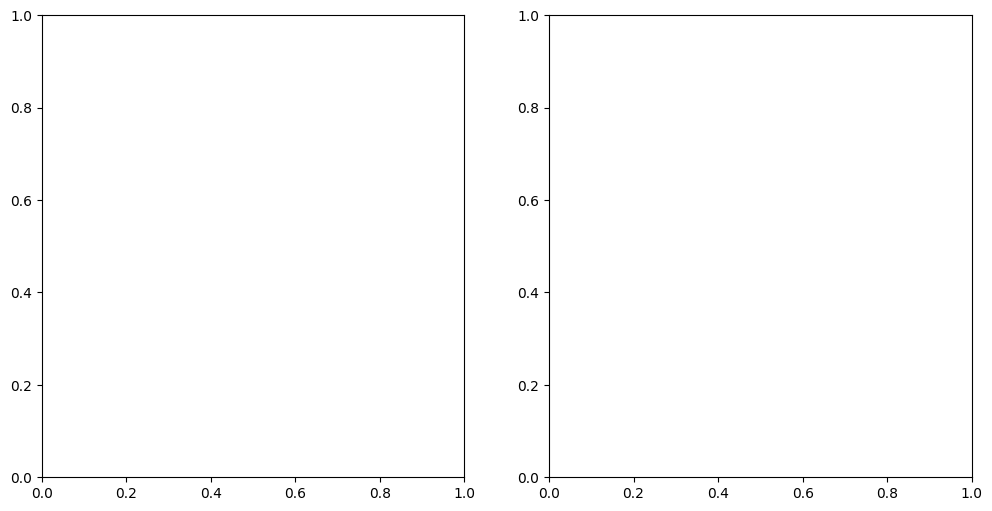

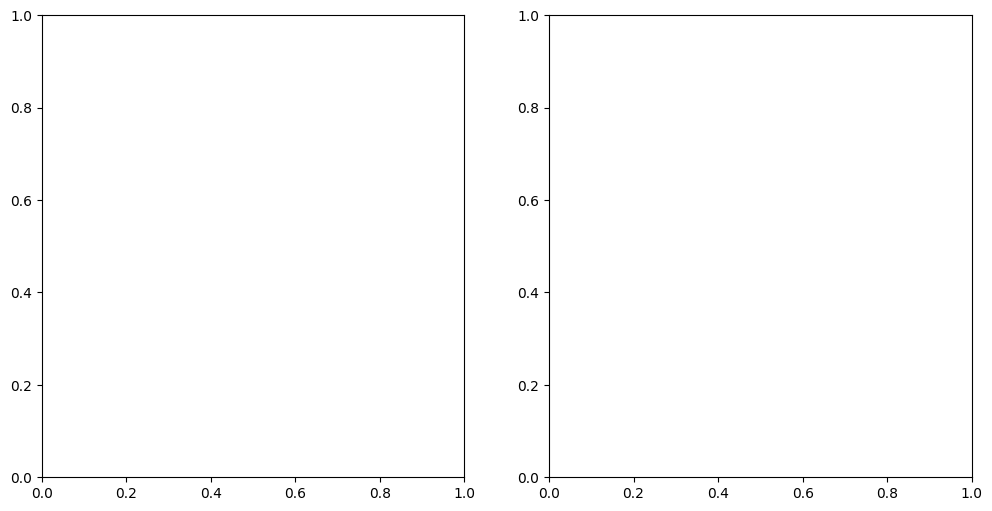

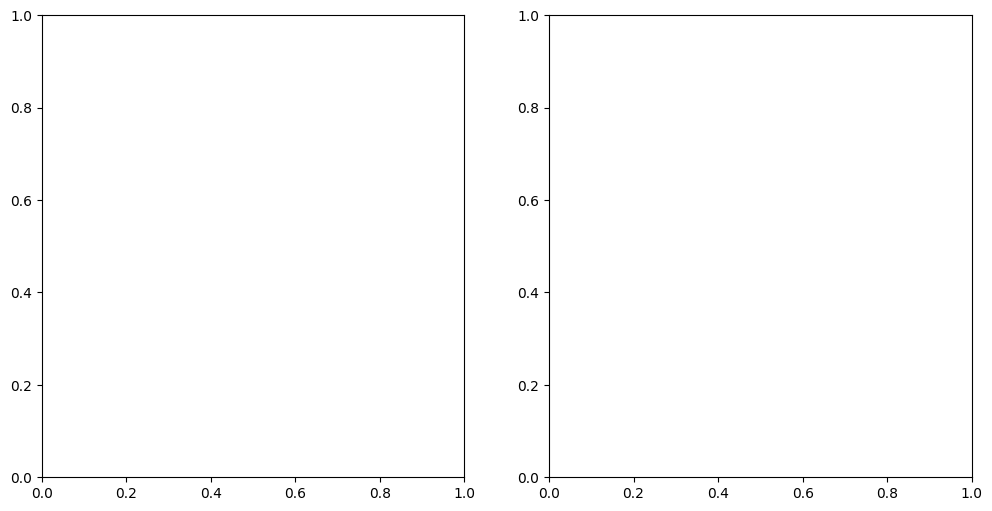

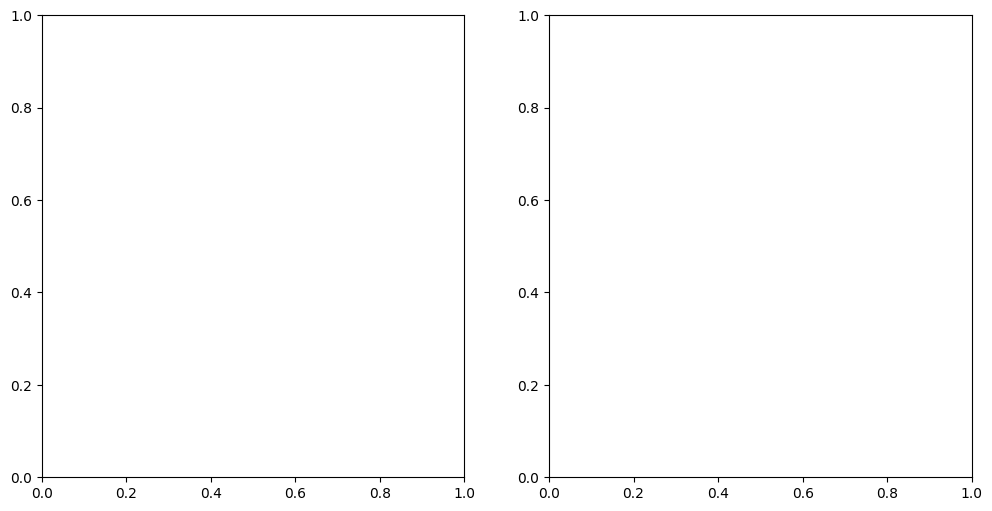

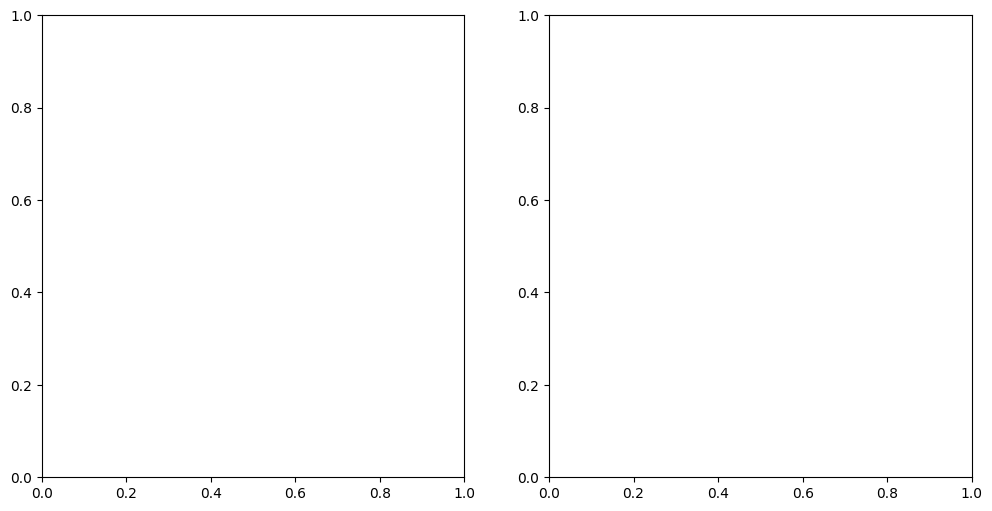

In [14]:
refinamento = [0.01, 0.04, 0.09, 0.16, 0.25]
for r in refinamento:
    print(f'Algoritmo refinamento_k_means - refinamento = {r}')
    inicio = time.time()
    points, distances, input_labels = FetchRealInput(df_drybeans)
    # print(input_labels)
        
    # Configurar o tamanho da figura
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Parte 1: Algoritmo refinamento_k_means

    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])

    centers, max_r = KmeansRefined(points, distances, r, k)
    # df = pd.DataFrame(columns=['x', 'y', 'label'])
    # print(len(centers))

    labels = []
    d = []
    for point in points:
        current_distance = 0
        nearest_center = 0
        for center in centers:
            if point == center:
                current_distance = 0
                nearest_center = center
                break
            distance = distances[points.index(point)][points.index(center)]
            # print(distance)
            if distance < current_distance or (current_distance == 0):
                current_distance = distance
                nearest_center = center
                # print(centers.index(nearest_center))
        d.append(current_distance) 
        labels.append(centers.index(nearest_center))
    max_r = max(d)
    print('Maior raio ganso:',max_r)
    # print(labels)
    ss = silhouette_score(np.array(points), labels)
    rs = rand_score(input_labels, labels)

    print('Silhouette ganso:', ss)
    print('Rand ganso:', rs)
    # # Plotar o resultado do greedy_k_means
    # ax[0].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    # ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
    # ax[0].set_title(f'Ganso - {max_r} max radius - {len(centers)} clusters - {r}')
    # ax[1].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
    #         verticalalignment='bottom', horizontalalignment='right',
    #         transform=ax[0].transAxes, color='black', fontsize=10,
    #         bbox=dict(facecolor='white', alpha=0.5))


    # Parte 2: K-means do sklearn
    X, y = np.array(points), input_labels
    kmeans = KMeans(n_clusters=len([x for i, x in enumerate(y) if x not in y[:i]]), random_state=42)
    labels = kmeans.fit_predict(X)
    distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
    max_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X)])

    # Imprimir métricas
    sil_score = silhouette_score(np.array(points), labels)
    rand_score_value = rand_score(y, labels)

    print('Maior raio sklearn:', max_r_sklearn)
    print('Silhouette sklearn:', sil_score)
    print('Rand sklearn:', rand_score_value)
    # Plotar o resultado do K-means
    # # ax[1].scatter(X.values[:, 0], X.values[:, 1], c=y, s=50, cmap='viridis')
    # ax[1].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    # centers = kmeans.cluster_centers_
    # ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    # ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
    #         verticalalignment='bottom', horizontalalignment='right',
    #         transform=ax[1].transAxes, color='black', fontsize=10,
    #         bbox=dict(facecolor='white', alpha=0.5))
    # # Configurar título e rótulos
    # ax[1].set_title(f'K-means Clustering - {max_r_sklearn} max radius')
    print(f'Tempo de execução: {time.time() - inicio:.2f}s')

    # Exibir os gráficos
    # plt.show()


In [ ]:

    labels = []
    d = []
    for point in points:
        current_distance = 0
        nearest_center = 0
        for center in centers:
            if point == center:
                current_distance = 0
                nearest_center = center
                break
            distance = distances[points.index(point)][points.index(center)]
            # print(distance)
            if distance < current_distance or (current_distance == 0):
                current_distance = distance
                nearest_center = center
                # print(centers.index(nearest_center))
        d.append(current_distance) 
        labels.append(centers.index(nearest_center))
    max_r = max(d)
    print('Maior raio ganso:',max_r)
    print(labels)
    ss = silhouette_score(np.array(points), labels)
    rs = rand_score(input_labels, labels)

    print('Silhouette ganso:', ss)
    print('Rand ganso:', rs)
    # # Plotar o resultado do greedy_k_means
    # ax[0].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    # ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
    # ax[0].set_title(f'Ganso - {max_r} max radius - {len(centers)} clusters - {r}')
    # ax[1].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
    #         verticalalignment='bottom', horizontalalignment='right',
    #         transform=ax[0].transAxes, color='black', fontsize=10,
    #         bbox=dict(facecolor='white', alpha=0.5))


    # Parte 2: K-means do sklearn
    X, y = np.array(points), input_labels
    kmeans = KMeans(n_clusters=len([x for i, x in enumerate(y) if x not in y[:i]]), random_state=42)
    labels = kmeans.fit_predict(X)
    distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
    max_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X)])

    # Imprimir métricas
    sil_score = silhouette_score(np.array(points), labels)
    rand_score_value = rand_score(y, labels)

    print('Maior raio sklearn:', max_r_sklearn)
    print('Silhouette sklearn:', sil_score)
    print('Rand sklearn:', rand_score_value)
    # Plotar o resultado do K-means
    # # ax[1].scatter(X.values[:, 0], X.values[:, 1], c=y, s=50, cmap='viridis')
    # ax[1].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    # centers = kmeans.cluster_centers_
    # ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    # ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
    #         verticalalignment='bottom', horizontalalignment='right',
    #         transform=ax[1].transAxes, color='black', fontsize=10,
    #         bbox=dict(facecolor='white', alpha=0.5))
    # # Configurar título e rótulos
    # ax[1].set_title(f'K-means Clustering - {max_r_sklearn} max radius')
    print(f'Tempo de execução: {time.time() - inicio:.2f}s')

    # Exibir os gráficos
    plt.show()


In [ ]:
type = 2 
metrics = []
csv_files = [f'data_{i}.csv' for i in range(10)]
refinamento = 0.04
radius = []
times = []
sillhouette_s = []
rand_s = []
points, distances, input_labels = FetchRealInput(df_drybeans)
for j in range(30):
    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])
    start = time.time()
    centers, max_r = KmeansRefined(points, distances, refinamento, k)
    end = time.time()
    labels = []
    r_v = []
    max_distance = 0

    for point in points:
        current_distance = 0
        nearest_center = 0
        for center in centers:
            if point == center:
                current_distance = 0
                nearest_center = center
                break
            point1 = np.array([point[0], point[1]])
            center1 = np.array([center[0], center[1]])
            distance = np.linalg.norm(point1 - center1,type)
            if distance < current_distance or (current_distance == 0):
                current_distance = distance
                nearest_center = center
        r_v.append(current_distance) 
        labels.append(centers.index(nearest_center))
        
    radius.append(max(r_v))
    times.append(end - start)
    sillhouette_s.append(silhouette_score(np.array(points), labels))
    rand_s = rand_score(input_labels, labels)
    #print(radius)
mean_radius = np.mean(radius)
mean_time = np.mean(times)
mean_sillhouette_s = np.mean(sillhouette_s)
mean_rand_s = np.mean(rand_s)
    
std_radius = np.std(radius)
std_sillhouette_s = np.std(sillhouette_s)
std_rand_s = np.std(rand_s)
    
metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])
df_greedy.to_csv('greedy_kmeans_drybeans_004.csv', index=False)

In [ ]:
df_greedy1 = pd.read_csv('greedy_kmeans_drybeans_001.csv')
df_greedy2 = pd.read_csv('greedy_kmeans_drybeans_004.csv')
df_greedy3 = pd.read_csv('greedy_kmeans_drybeans_009.csv')
df_greedy4 = pd.read_csv('greedy_kmeans_drybeans_016.csv')
df_greedy5 = pd.read_csv('greedy_kmeans_drybeans_025.csv')
df_media1 = df_greedy1 / df_sklearn
df_media2 = df_greedy2 / df_sklearn
df_media3 = df_greedy3 / df_sklearn
df_media4 = df_greedy4 / df_sklearn
df_media5 = df_greedy5 / df_sklearn
ax1 = df_media1[['mean_radius']].plot(kind='density', figsize=(10, 5), legend='001')
ax2 = df_media2[['mean_radius']].plot(kind='density', ax=ax1, legend='004')
ax3 = df_media3[['mean_radius']].plot(kind='density', ax=ax1, legend='009')
ax4 = df_media4[['mean_radius']].plot(kind='density', ax=ax1, legend='016')
ax5 = df_media5[['mean_radius']].plot(kind='density', ax=ax1, legend='025')
plt.legend(['p = 0.01', 'p = 0.04', 'p = 0.09', 'p = 0.16', 'p = 0.25'])
plt.title('Densidade do raio médio - algoritmo de refinamento de raios')